# Day 8: Anomaly Detection and Recommender Systems

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)
import scipy.io
import scipy.optimize

## 1 Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},...,x^{(m)}\}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection
algorithm to a larger dataset with many dimensions.

In [2]:
data = scipy.io.loadmat('data/ex8data1.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval']
print(X.shape)
print(X_val.shape, y_val.shape)

(307, 2)
(307, 2) (307, 1)


In [3]:
# Vusualize the data
def plotData(X, newFig=False):
    if newFig:
        plt.figure(figsize=(8, 6))
    plt.plot(X[:, 0], X[:, 1], 'bx', markersize=5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')

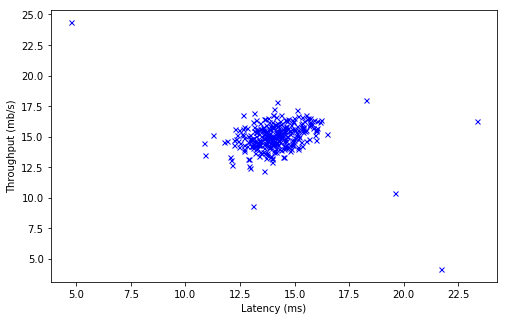

In [4]:
plotData(X)

### 1.1 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

Given a training set $\{x^{(1)}, ...,x^{(m)}\}$ (where $x^{(i)} \in R^n$) you want to estimate the Gaussian distribution for each of the features xi. For each feature i = 1...n, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the *i*-th dimension $\{x^{(1)}, ...,x^{(m)}\}$ (the *i*-th dimension of each example).

The Gaussian distribution is given by
$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

In [5]:
def gaus(X, mu, sig):
    '''Function to compute the gaussian return values for a feature.'''
    m = X.shape[0]
    n = X.shape[1]
    if np.ndim(sig) == 1:
        sig = np.diag(sig)
    
    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sig)))
    inv = np.linalg.inv(sig)
    e = np.zeros((m,1))
    for irow in range(m):
        xrow = X[irow]
        e[irow] = np.exp(-0.5*((xrow-mu).T).dot(inv).dot(xrow-mu))
    return norm*e

### 1.2 Estimating parameters for a Gaussian

To estimate the mean, you will use:
$$\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}$$
and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [6]:
def estimateGaussian(X, multivariate=True):
    '''Function that given a feature matrix X that is (mxn)
    returns a mean vector and a sigma-squared vector that are
    both (nx1) in shape.'''
    m = X.shape[0]
    mu = np.mean(X, axis=0)
    if not multivariate:
        sig = np.sum(np.square(X-mu), axis=0)/float(m)
        return mu, sig
    else:
        sig = ((X-mu).T.dot(X-mu))/float(m)
        return mu, sig

In [7]:
mu, sig = estimateGaussian(X, multivariate=True)

In [8]:
# Visualizing the Gaussian probability contours
def plotContours(mu, sig, newFig=False):
    x = np.arange(0, 30, .5)
    y = np.arange(0, 30, .5)
    meshx, meshy = np.meshgrid(x, y)
    coord_list = [entry.ravel() for entry in (meshx, meshy)]
    points = np.vstack(coord_list).T
    z = gaus(points, mu, sig)
    z = z.reshape((x.shape[0], x.shape[0]))

    if newFig:
        plt.figure(figsize=(6,4))
    
    cont_levels = [10**e for e in range(-20, 0, 3)]
    cont = plt.contour(meshx, meshy, z, levels=cont_levels)

    plt.title('Gaussian Contours',fontsize=16)

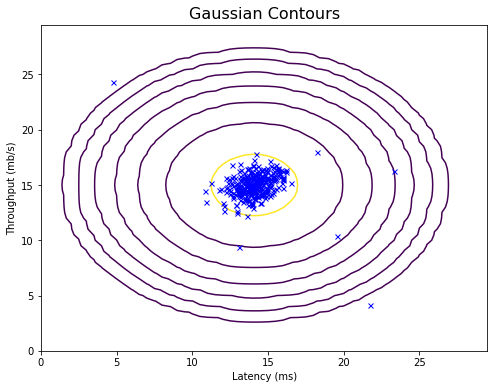

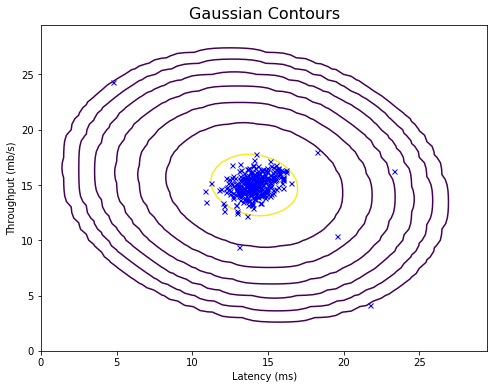

In [9]:
# First contours without using multivariate gaussian:
plotData(X, newFig=True)
plotContours(*estimateGaussian(X, multivariate=False), newFig=False)

# Then contours with multivariate gaussian:
plotData(X, newFig=True)
plotContours(*estimateGaussian(X, multivariate=True), newFig=False)

### 1.3 Selecting the threshold, $\epsilon$

In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the F1 score on a cross validation set.
$$F_1 = \frac{2*pre*rec}{pre+rec}$$
where:
$prec = \frac{tp}{tp+fp}$ , $rec = \frac{tp}{tp+fn}$

In [10]:
def computeF1(predVec, trueVec):
    '''Implementing compute F1 score based on precision and recall values'''
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0])
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0])
                    if trueVec[x]]) / float(np.sum(trueVec))
    
    return 2*P*R/(P+R) if (P+R) else 0

In [11]:
def selectThreshold(y_cv, p_CVs):
    '''Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.'''
    
    # Make a list of possible epsilon values
    steps = 1000
    epses = np.linspace(np.min([p_CVs]),np.max(p_CVs), steps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (y_cv == 1).flatten()
    for eps in epses:
        predVec = p_CVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print("Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps))
    return bestF1, bestEps

In [12]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
p_CVs = gaus(X_val, mu, sig)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(y_val, p_CVs)

Best F1 is 0.875000, best eps is 9.075e-05.


In [13]:
def plotAnomalies(X, bestEps, newFig = False, multivariate = True):
    ps = gaus(X, *estimateGaussian(X, multivariate))
    anoms = np.array([X[x] for x in range(X.shape[0]) if ps[x] < bestEps])
    if newFig: plt.figure(figsize=(6,4))
    plt.scatter(anoms[:,0], anoms[:,1], s=80, facecolors='none', edgecolors='r')

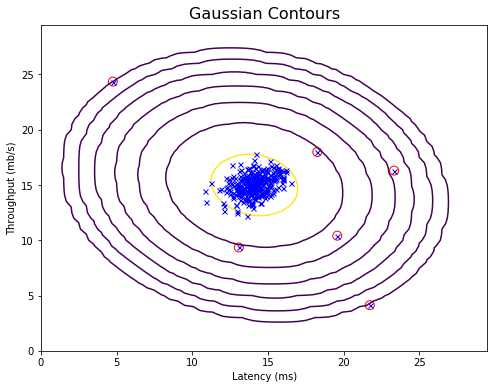

In [14]:
plotData(X, newFig=True)
plotContours(mu, sig, newFig=False)
plotAnomalies(X, bestEps, newFig=False, multivariate=True)

### 1.4 High dimensional dataset

In this part, you will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this
dataset, each example is described by 11 features, capturing many more properties of your compute servers.

In [15]:
data = scipy.io.loadmat('data/ex8data2.mat')
X2 = data['X']
X_val2 = data['Xval']
y_val2 = data['yval']
print(X2.shape)
print(X_val2.shape, y_val2.shape)

(1000, 11)
(100, 11) (100, 1)


In [16]:
mu, sig = estimateGaussian(X2, multivariate=False)
ps = gaus(X2, mu, sig)
ps_CV = gaus(X_val2, mu, sig)

# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
p_CVs = gaus(X_val2, mu, sig)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(y_val2, p_CVs)
anoms = [X2[x] for x in range(X2.shape[0]) if ps[x] < bestEps]
print('# of anomalies found: ',len(anoms))

Best F1 is 0.615385, best eps is 1.379e-18.
# of anomalies found:  117


## 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.

### 2.1 Movie ratings dataset

In [17]:
movies = scipy.io.loadmat('data/ex8_movies.mat')
Y = movies['Y']
R = movies['R']

nm, nu = Y.shape
print(Y.shape)
print(R.shape)

(1682, 943)
(1682, 943)


### 2.2 Collaborative filtering learning algorithm

In [18]:
params = scipy.io.loadmat('data/ex8_movieParams.mat')
X = params['X']
theta = params['Theta']
nu = int(params['num_users'])
nm = int(params['num_movies'])
nf = int(params['num_features'])

# For now, reduce the data set size so that this runs faster
nu = 4; nm = 5; nf = 3
X = X[:nm, :nf]
theta = theta[:nu, :nf]
Y = Y[:nm, :nu]
R = R[:nm, :nu]

In [19]:
def flattenParams(X, theta):
    '''Hand this function an X matrix and a Theta matrix and it will flatten
    it into into one long (nm*nf + nu*nf,1) shaped numpy array.'''
    return np.concatenate((X.flatten(), theta.flatten()))

# A utility function to re-shape the X and theta will probably come in handy
def reshapeParams(flattened_XandTheta, nm, nu, nf):
    
    reX = flattened_XandTheta[:int(nm*nf)].reshape((nm,nf))
    reTheta = flattened_XandTheta[int(nm*nf):].reshape((nu,nf))
    
    return reX, reTheta

#### 2.2.1 Collaborative filtering cost function and 2.2.3 Regularized cost function

In [20]:
def cofiCostFunc(params, Y, R, nu, nm, nf, lambd = 0.):
    
    # Unfold the X and Theta matrices from the flattened params
    X, theta = reshapeParams(params, nm, nu, nf)
  
    # Note: 
    # X Shape is (nm x nf), Theta shape is (nu x nf), Y and R shape is (nm x nu)
    # Behold! Complete vectorization
    
    # First dot theta and X together such that you get a matrix the same shape as Y
    term1 = X.dot(theta.T)
    
    # Then element-wise multiply that matrix by the R matrix
    # so only terms from movies which that user rated are counted in the cost
    term1 = np.multiply(term1, R)
    
    # Then subtract the Y- matrix (which has 0 entries for non-rated
    # movies by each user, so no need to multiply that by myR... though, if
    # a user could rate a movie "0 stars" then myY would have to be element-
    # wise multiplied by myR as well) 
    # also square that whole term, sum all elements in the resulting matrix,
    # and multiply by 0.5 to get the cost
    cost = 0.5 * np.sum(np.square(term1-Y))
    
    # Regularization stuff
    cost += (lambd/2.) * np.sum(np.square(theta))
    cost += (lambd/2.) * np.sum(np.square(X))
    
    return cost

In [21]:
# Run your cost function. You should expect to see an output of 22.22."
print('Cost with nu = 4, nm = 5, nf = 3 is %0.2f.' % 
    cofiCostFunc(flattenParams(X, theta), Y, R, nu, nm, nf))
    
# With lambda = 1.5 you should expect to see an output of 31.34."
print('Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is %0.2f.' %
    cofiCostFunc(flattenParams(X, theta), Y, R, nu, nm, nf, lambd=1.5))

Cost with nu = 4, nm = 5, nf = 3 is 22.22.
Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is 31.34.
